In [1]:
import torch
import torch.nn.functional as F
import torchmetrics
import lightning as L
import torchvision
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np
############################################
#For DataModule and Model building purposes#
############################################

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

### This lists the models

In [2]:
entrypoints = torch.hub.list('pytorch/vision', force_reload=True)
for e in entrypoints:
    if 'resnet' in e:
        print(e)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /home/codespace/.cache/torch/hub/main.zip


deeplabv3_resnet101
deeplabv3_resnet50
fcn_resnet101
fcn_resnet50
resnet101
resnet152
resnet18
resnet34
resnet50
wide_resnet101_2
wide_resnet50_2


In [3]:
pytorch_model = torch.hub.load('pytorch/vision', 'resnet18', weights=None)

Using cache found in /home/codespace/.cache/torch/hub/pytorch_vision_main


### Create the cifar datamodule

In [36]:
class Cifar10DataModule(L.LightningDataModule):
    def __init__(self, data_path="./", batch_size=64, num_workers=0, height_width=(32,32)):
        super().__init__()
        self.data_path=data_path
        self.batch_size=batch_size
        self.num_workers=num_workers
        self.height_width=height_width

    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path, download=True)

        self.train_transform = transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor(),
            ]
        )

        self.test_transform = transforms.Compose(
            [
                transforms.Resize(self.height_width),
                transforms.ToTensor(),
            ]
        )

        return

    def setup(self, state=None):
        train=datasets.CIFAR10(
            root=self.data_path,
            train=True,
            transform=self.train_transform,
            download=False
        )
        

        self.test=datasets.CIFAR10(
            root=self.data_path,
            train=False,
            transform=self.test_transform,
            download=False
        )

        self.train, self.valid  = random_split(train, lengths=[45000, 5000])


    def train_loader(self):
        train_loader=DataLoader(
            dataset=self.train,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_loader(self):
        train_loader=DataLoader(
            dataset=self.valid,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return val_loader

    def test_loader(self):
        test_loader=DataLoader(
            dataset=self.test,
            batch_size=self.batch_size,
            drop_last=True,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return test_loader
    

### Create the Lightning Model

In [37]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model=model
        self.learning_rate=learning_rate

        self.save_hyperparameters(ignore=['model'])

        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=10)
        self.test_acc = torchmetrics.Accuracy(task='mutlticlass', num_classes=10)


    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels=batch
        logits = self(features)


        loss = F.cross_entroy(logits, true_lables)
        predicted_labels = torch.argmax(logits, dim=1)
        return loss, true_lables, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log('train_loss',loss)
        self.train_acc(predicted_labels, true_labels)
        self.log('train_acc', self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)

        self.log('val_loss',loss, prog_bar=True)
        self.val_acc(predicted_labels, true_labels)
        self.log('val_acc', self.val_acc, prog_bar=True, on_epoch=True, on_step=False
        )

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self.shared_step(batch)

        self.test_acc(predicted_labels, true_labels)
        self.log('test_loss',loss,self.test_acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer=torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer
    

In [38]:
def plot_loss_and_acc(
    log_dir, loss_ylim=(0.0, 0.9), acc_ylim=(0.7, 1.0), save_loss=None, save_acc=None
):

    metrics = pd.read_csv(f"{log_dir}/metrics.csv")

    aggreg_metrics = []
    agg_col = "epoch"
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggreg_metrics.append(agg)

    df_metrics = pd.DataFrame(aggreg_metrics)
    df_metrics[["train_loss", "val_loss"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
    )

    plt.ylim(loss_ylim)
    if save_loss is not None:
        plt.savefig(save_loss)

    df_metrics[["train_acc", "val_acc"]].plot(
        grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
    )

    plt.ylim(acc_ylim)
    if save_acc is not None:
        plt.savefig(save_acc)

In [39]:
L.pytorch.seed_everything(12)

dm = Cifar10DataModule(batch_size=64)
dm.prepare_data()
dm.setup()

Global seed set to 12


Files already downloaded and verified


Make a plot to see the samples

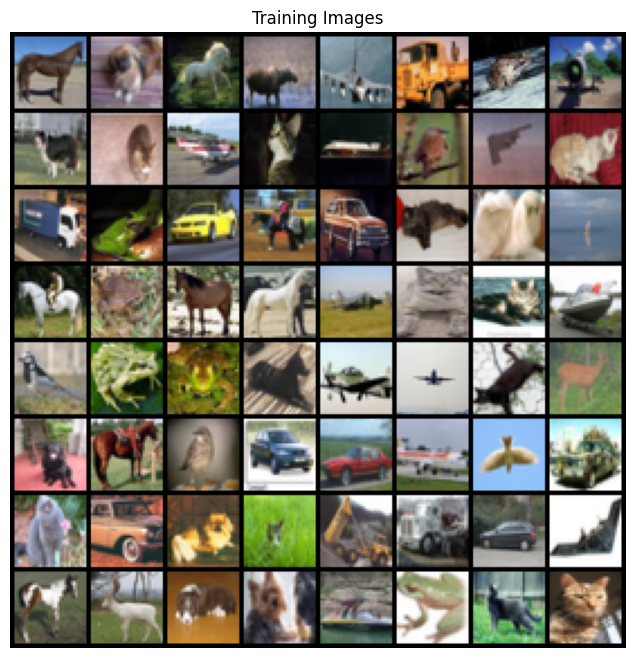

In [41]:
for images, labels in dm.train_loader():
    break

plt.figure(figsize=(8,8))
plt.title('Training Images')
plt.axis('off')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64],
    padding=2,
    normalize=True),
    (1,2,0)))
plt.show()

Custom Data Transform

In [43]:
from torchvision import transforms

train_transform = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.Resize((150,150)),
        transforms.RandomCrop((128,128)),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ]
)

test_transform = transforms.Compose(
    [   
        transforms.ToPILImage(),
        transforms.Resize((150, 150)),
        transforms.CenterCrop((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [49]:
dm = Cifar10DataModule(batch_size=64, num_workers=8)


L.seed_everything(123)
dm.prepare_data()
dm.setup()

Global seed set to 123


 45%|████▌     | 76840960/170498071 [00:06<00:08, 11535791.81it/s]


KeyboardInterrupt: 

### Transform the data

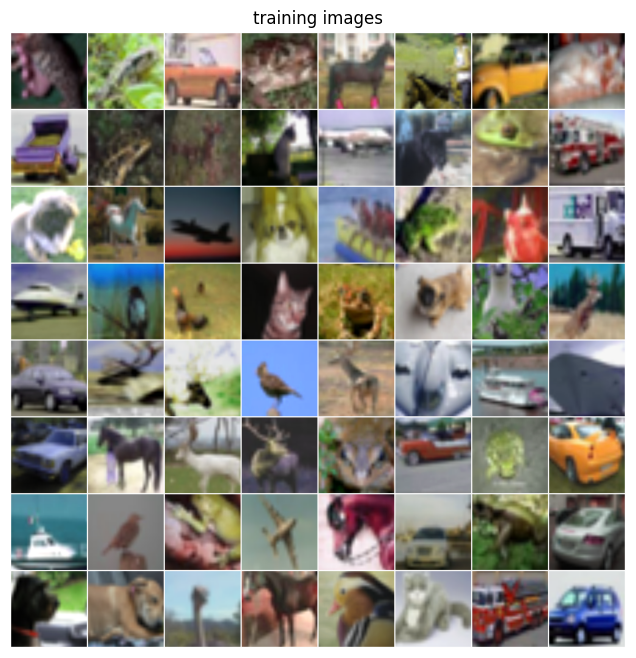

In [46]:
for images, labels in dm.train_loader():
    break


transformed = [train_transform(i) for i in images]

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    transformed[:64],
    padding=2,
    pad_value=1.0,
    normalize=True),
    (1,2,0)))

plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


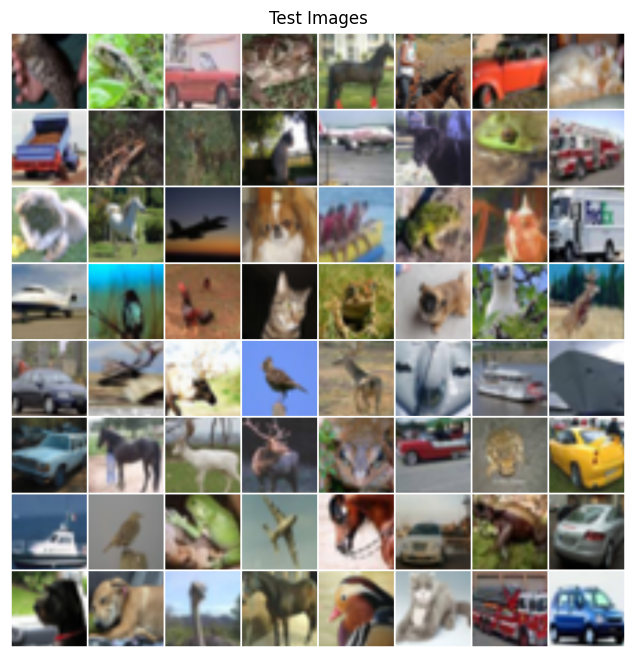

In [47]:
test_transformed = [test_transform(i) for i in images]

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Test Images')
plt.imshow(np.transpose(torchvision.utils.make_grid(
    test_transformed[:64],
    padding=3,
    pad_value=2,
    normalize=True),
    (1,2,0)))

## Looking at the restnet baseline performance

In [ ]:
## We are doing this all again just to make sure no other package overwriting and 